In [1]:
# Import the needed Packages
# FMU Simulation
import MoBASimulator as mb
# Numpy
import numpy as np
# Pandas for storage
import pandas as pd
# Algorithms
import Algorithms as alg
from Algorithms import TUBScolorscale

In [2]:
result = pd.DataFrame(columns=('T_A', 'Q_C', 'K11', 'K12', 'K21', 'K22', 'T11', 'T12', 'T21', 'T22', 'L11', 'L12', 'L21', 'L22'))

# Load a Model
sim = mb.Simulator()
sim.clear()
sim.loadModel("C:/Users/juliu/Documents/Thesis/Modelica/FMU/2_2_Physical/Physical_Full_Input.fmu")
# Show log window
sim.showLogWindow()
sim.showParameterDialog()
# Set the simulation Parameter
sim_time = 6e4
T_amb = 295 # Ambient Temperatures in K
#times = [0,5e3,8e3]
Q_C = -60e3 #[-60e3,-75e3,-90e3] # Heats in kJ/s as Timeinput
stepTime = 5e4 # Time for the step
step_N = -.5 # height of the step for fan
step_A = 0.3 # Height of the step for valve
T_amb

295

In [3]:
for number in range(1):
    # First experiment Fan -> Temp / Pressure
    sim.reloadModel()
    # Set the Parameter
    sim.set({"fmu.T_A":T_amb,"fmu.Q_C":Q_C,
         "fmu.booleanStep.startTime":stepTime-1.0,
        "fmu.step_T.startTime": stepTime, "fmu.step_T.height": step_N,
        "fmu.step_P.startTime": sim_time, "fmu.step_P.height": 0.})
    # Slowly increase the heat
    #sim.setInputTable({"time": times, "fmu.Q_C": Q_C})
    #sim.showParameterDialog()
    # Simulate
    res_Fan = sim.simulate(3,sim_time)

    # Repeat for Valve -> Temp/Pressure
    # Physical : Valve -> Pressure is negat
    sim.reloadModel()
    # Set the Parameter
    sim.set({"fmu.T_A":T_amb,"fmu.Q_C":Q_C,
         "fmu.booleanStep.startTime":stepTime-1.0,
        "fmu.step_T.startTime": sim_time, "fmu.step_T.height": 0.,
        "fmu.step_P.startTime": stepTime, "fmu.step_P.height": step_A})
    # Slowly increase the Heat
    #sim.setInputTable({"time": times, "fmu.Q_C": Q_C})
    # Simulate
    res_Valve = sim.simulate(3,sim_time)

    # Get the signals
    y_P = res_Fan["fmu.p_H"]
    u_P =  step_A*np.ones_like(y_P)
    y_T = res_Fan["fmu.T_H"]
    u_T =  step_N*np.ones_like(y_T)
    time = res_Fan["time"]

    # Rescale the signals for identification
    # Get Data after Step -> For the Fan \delta T approx 400 s.
    # Get Temperature data
    y_T_I = y_T[np.where((time>=stepTime) & (time < (stepTime+400.)))]
    y_T_I = y_T_I-y_T_I[0]
    u_T_I = u_T[np.where((time>=stepTime) & (time <(stepTime+400.)))]
    t_T_I = time[np.where((time>=stepTime) & (time < (stepTime+400.)))]-stepTime

    # Same for pressure
    y_P_I = y_P[np.where((time>=stepTime) & (time < stepTime+400.))]
    y_P_I = y_P_I-y_P_I[0] 
    u_P_I = u_P[np.where((time>=stepTime) & (time < stepTime+400.))]
    t_P_I = time[np.where((time>=stepTime) & (time < stepTime+400.))]-stepTime

    # The needed Parameter
    K = np.zeros((2,2))
    T = np.zeros((2,2))
    L = np.zeros((2,2))

    # Identify from Fan to Temp [0][0] and from Fan to Pressure[1][0]
    K[0][0],T[0][0],L[0][0]=alg.Integral_Identification(y_T_I,u_T_I,t_T_I)
    K[1][0],T[1][0],L[1][0]=alg.Integral_Identification(y_P_I,u_T_I,t_P_I)

    # Get the signals
    steptime = sim.get("fmu.booleanStep.startTime")
    y_P = res_Valve["fmu.p_H"]
    u_P =  step_A*np.ones_like(y_P)
    y_T = res_Valve["fmu.T_H"]
    u_T =  step_N*np.ones_like(y_T)
    time = res_Valve["time"]

    # Rescale the signals for identification
    # Get Data after Step
    y_T_I = y_T[np.where((time>=steptime) & (time < (steptime+600.)))]
    y_T_I = y_T_I-y_T_I[0]
    u_T_I = u_T[np.where((time>=steptime) & (time <(steptime+600.)))]
    t_T_I = time[np.where((time>=steptime) & (time < (steptime+600.)))]-steptime

    # Same for P
    y_P_I = y_P[np.where((time>=steptime) & (time < steptime+600.))]
    y_P_I = y_P_I-y_P_I[0]
    u_P_I = u_P[np.where((time>=steptime) & (time < steptime+600.))]
    t_P_I = time[np.where((time>=steptime) & (time < steptime+600.))]-steptime

    #Identify from Valve to Temp [0][1] and from Valve to Pressure[1][1]
    K[0][1],T[0][1],L[0][1]=alg.Integral_Identification(y_T_I,u_P_I,t_T_I)
    K[1][1],T[1][1],L[1][1]=alg.Integral_Identification(y_P_I,u_P_I,t_P_I)

    #result.loc[number,:2] = [T_amb[number], Q_C[-1]]
    #result.loc[number,2:] = np.hstack((K.flatten(),np.hstack((T.flatten(),L.flatten())))).tolist()
    #result.to_csv('PhysicalIdentification_Test.csv', sep=';')
    #print(result)

Error - Small delay - Using 0 instead


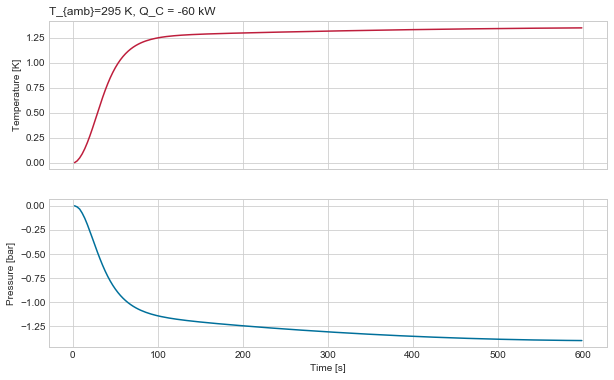

In [78]:
import matplotlib.pyplot as plt
from Algorithms import TUBScolorscale

# Make a plot
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-whitegrid')

plt.clf

fig, ax = plt.subplots(2, sharex=True, figsize = (10,6))
ax[0].set_title("T_{amb}=295 K, Q_C = -60 kW", loc = "left")
ax[0].plot(t_T_I,y_T_I, color =TUBScolorscale[1])
#ax[0].plot(time[np.where(time>5000)],y_T2[np.where(time>5000)], color =TUBScolorscale[9], label = "R2D2")
#ax[0].plot(time[np.where(time>5000)],y_T3[np.where(time>5000)], color =TUBScolorscale[3], label = "R2D2")
#ax[0].plot(time[np.where(time>5000)],y_TR[np.where(time>5000)], color =TUBScolorscale[0])
ax[0].set_ylabel("Temperature [K]")
#plt.legend(loc="upper right")
#ax[0].legend(loc="lower right")
# Make Annotations
#ax[1].annotate('Disturbance of \Delta A_{eff} = -0.2  ',
#            xy=(6000, 68.49), xycoords='data',
#            xytext=(6500, 68.8), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].plot(t_T_I,y_P_I, color =TUBScolorscale[9])
#ax[1].plot(time[np.where(time>5000)],y_P2[np.where(time>5000)], color =TUBScolorscale[9])
#ax[1].plot(time[np.where(time>5000)],y_P3[np.where(time>5000)], color =TUBScolorscale[3])
#ax[1].plot(time[np.where(time>5000)],y_PR[np.where(time>5000)], color =TUBScolorscale[0])
ax[1].set_ylabel("Pressure [bar]")
#ax[0].annotate('Disturbance of \Delta n = -0.5  ',
#            xy=(10000, 293), xycoords='data',
#            xytext=(10500, 293.1), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].set_xlabel("Time [s]")


plt.savefig("Identification_Example.svg")
plt.show()

In [70]:
# Make a controller
#KY, B, D = alg.Control_Decoupled(K,T,L,0.5*np.ones_like(K))
KY, B, D = alg.Control_Decentral(K,T,L, pairing = [0,1])
#Reload Model
sim.reloadModel()
# Set the parameter for a controller simulation
params = {"fmu.step_P.startTime":6e3,"fmu.step_P.height":-.2, # Input disturbance from Valve
          "fmu.step_T.startTime":10e3, "fmu.step_T.height":-.5, # Input disturbance from Fan
          "fmu.step_PR.startTime":6e5,"fmu.step_PR.height": 1, # Set Point change Pressure
          "fmu.step_TR.startTime":10e5, "fmu.step_TR.height": 1, # Set Point change Temperature
          "fmu.booleanStep.startTime":10e5} # Never turn off the controller
for outputs in range(1,3):
    for inputs in range(1,3):
        params.update({"fmu.multivariable_Controller.KP["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][0]})
        params.update({"fmu.multivariable_Controller.KI["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][1]})
        params.update({"fmu.multivariable_Controller.D["+str(outputs)+","+str(inputs)+"]": D[outputs-1][inputs-1]})
        params.update({"fmu.multivariable_Controller.B["+str(outputs)+","+str(inputs)+"]": B[outputs-1][inputs-1]})
sim.set(params)
sim.showParameterDialog()
sim.set({"fmu.T_A": T_amb, "fmu.Q_C": Q_C})
# Simulate the closed loop
res_Control_Decentral = sim.simulate(1,15e3)

In [ ]:
# Make a controller
KY, B, D = alg.Control_Decoupled(K,T,L,10*np.ones_like(K), pairing = [0,1])
#KY, B, D = alg.Control_Decentral(K,T,L)
#Reload Model
sim.reloadModel()
# Set the parameter for a controller simulation
params = {"fmu.step_P.startTime":6e3,"fmu.step_P.height":-.2, # Input disturbance from Valve
          "fmu.step_T.startTime":10e3, "fmu.step_T.height":-.5, # Input disturbance from Fan
          "fmu.step_PR.startTime":6e5,"fmu.step_PR.height": 1, # Set Point change Pressure
          "fmu.step_TR.startTime":10e5, "fmu.step_TR.height": 1, # Set Point change Temperature
          "fmu.booleanStep.startTime":10e5} # Never turn off the controller
for outputs in range(1,3):
    for inputs in range(1,3):
        params.update({"fmu.multivariable_Controller.KP["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][0]})
        params.update({"fmu.multivariable_Controller.KI["+str(outputs)+","+str(inputs)+"]": KY[outputs-1][inputs-1][1]})
        params.update({"fmu.multivariable_Controller.D["+str(outputs)+","+str(inputs)+"]": D[outputs-1][inputs-1]})
        params.update({"fmu.multivariable_Controller.B["+str(outputs)+","+str(inputs)+"]": B[outputs-1][inputs-1]})
sim.set(params)
sim.showParameterDialog()
sim.set({"fmu.T_A": T_amb, "fmu.Q_C": Q_C})
# Simulate the closed loop
res_Control_Decoupled = sim.simulate(.5,15e3)

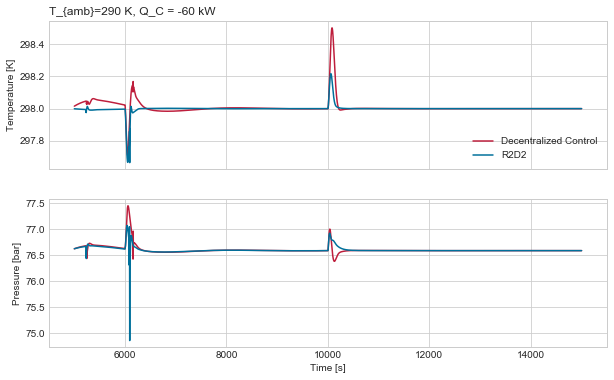

In [72]:
import matplotlib.pyplot as plt
from Algorithms import TUBScolorscale

# Make a plot
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-whitegrid')

plt.clf

# Get the signals
y_T1 = res_Control_Decentral["fmu.T_H"]
y_P1 = res_Control_Decentral["fmu.p_H"]
y_T2 = res_Control_Decoupled["fmu.T_H"]
y_P2 = res_Control_Decoupled["fmu.p_H"]
y_T3 = res_Control_Detuned["fmu.T_H"]
y_P3 = res_Control_Detuned["fmu.p_H"]
time = res_Control_Decentral["time"]
# Inputs
#y_N = res_Control_Decentral["fmu.add_T.y"]
#y_A = res_Control_Decentral["fmu.add_P.y"]
# SetPoint
#y_TR = res_Control_Decentral["fmu.T_R.y"]
#y_PR = res_Control_Decentral["fmu.P_R.y"]

plt.clf
fig, ax = plt.subplots(2, sharex=True, figsize = (10,6))
ax[0].set_title("T_{amb}=290 K, Q_C = -60 kW", loc = "left")
ax[0].plot(time[np.where(time>5e4)],y_T1[np.where(time>5e4)], color =TUBScolorscale[1], label = "Decentralized Control")
ax[0].plot(time[np.where(time>5e4)],y_T2[np.where(time>5e4)], color =TUBScolorscale[9], label = "R2D2")
ax[0].set_ylabel("Temperature [K]")
#plt.legend(loc="upper right")
ax[0].legend(loc="lower right")
# Make Annotations
#ax[1].annotate('Disturbance of \Delta A_{eff} = -0.2  ',
#            xy=(6000, 68.49), xycoords='data',
#            xytext=(6500, 68.8), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].plot(time[np.where(time>5000)],y_P1[np.where(time>5000)], color =TUBScolorscale[1])
ax[1].plot(time[np.where(time>5000)],y_P2[np.where(time>5000)], color =TUBScolorscale[9])
#ax[1].plot(time[np.where(time>5000)],y_P3[np.where(time>5000)], color =TUBScolorscale[3])
#ax[1].plot(time[np.where(time>5000)],y_PR[np.where(time>5000)], color =TUBScolorscale[0])
ax[1].set_ylabel("Pressure [bar]")
#ax[0].annotate('Disturbance of \Delta n = -0.5  ',
#            xy=(10000, 293), xycoords='data',
#            xytext=(10500, 293.1), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].set_xlabel("Time [s]")


plt.savefig("DisturbanceExample.svg")
plt.show()

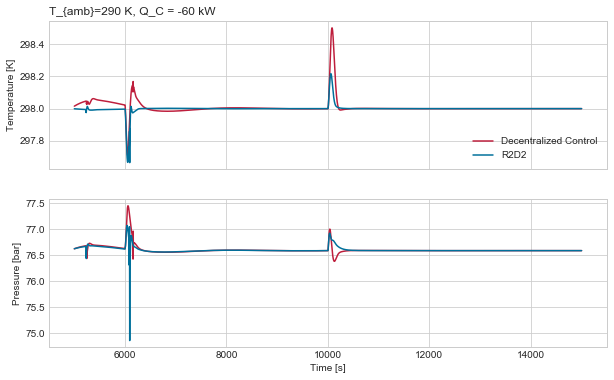

In [72]:
import matplotlib.pyplot as plt
from Algorithms import TUBScolorscale

# Make a plot
plt.rcParams['svg.fonttype'] = 'none'
plt.style.use('seaborn-whitegrid')

plt.clf


plt.clf
fig, ax = plt.subplots(2, sharex=True, figsize = (10,6))
ax[0].set_title("T_{amb}=295 K, Q_C = -60 kW", loc = "left")
ax[0].plot(time[np.where(time>5000)],y_T1[np.where(time>5000)], color =TUBScolorscale[1], label = "Decentralized Control")
ax[0].plot(time[np.where(time>5000)],y_T2[np.where(time>5000)], color =TUBScolorscale[9], label = "R2D2")
#ax[0].plot(time[np.where(time>5000)],y_T3[np.where(time>5000)], color =TUBScolorscale[3], label = "R2D2")
#ax[0].plot(time[np.where(time>5000)],y_TR[np.where(time>5000)], color =TUBScolorscale[0])
ax[0].set_ylabel("Temperature [K]")
#plt.legend(loc="upper right")
ax[0].legend(loc="lower right")
# Make Annotations
#ax[1].annotate('Disturbance of \Delta A_{eff} = -0.2  ',
#            xy=(6000, 68.49), xycoords='data',
#            xytext=(6500, 68.8), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].plot(time[np.where(time>5000)],y_P1[np.where(time>5000)], color =TUBScolorscale[1])
ax[1].plot(time[np.where(time>5000)],y_P2[np.where(time>5000)], color =TUBScolorscale[9])
#ax[1].plot(time[np.where(time>5000)],y_P3[np.where(time>5000)], color =TUBScolorscale[3])
#ax[1].plot(time[np.where(time>5000)],y_PR[np.where(time>5000)], color =TUBScolorscale[0])
ax[1].set_ylabel("Pressure [bar]")
#ax[0].annotate('Disturbance of \Delta n = -0.5  ',
#            xy=(10000, 293), xycoords='data',
#            xytext=(10500, 293.1), textcoords='data',
#            arrowprops=dict(arrowstyle="->"))
ax[1].set_xlabel("Time [s]")


plt.savefig("DisturbanceExample.svg")
plt.show()